### Basic Concepts: Nodes, Edges & State

## Understanding State Machines in LangGraph

LangGraph adopts a state machine (graph-based) approach to orchestrate LLM workflows. This architecture models applications as collections of:

### Key Components

1. **Nodes**:
    
    - Represent discrete steps in your workflow
    - Each node has a single responsibility (data transformation, validation, decision-making)
    - Promotes modular design that reduces complexity
    - Enables isolated testing and maintenance
2. **Edges**:
    
    - Define the order in which nodes run
    - Act as directed connections between workflow steps
    - Ensure outputs from one node become inputs to the next
    - Create explicit control over data flow
3. **Shared State**:
   
	- The State is a shared data structure and represents the current snapshot of the app.
    - Carries data between nodes throughout the execution
    - Each node reads from, modifies, or augments the state according to its role
    - Avoids tight coupling seen in monolithic guard classes
    - Provides transparency about what data passes to each node

LangGraph is created to define cyclical graphs. Graphs consist of the following elements:

- Nodes represent actual actions and can be either LLMs, agents or functions. Also, a special END node marks the end of execution.
- Edges connect nodes and determine the execution flow of your graph. There are basic edges that simply link one node to another and conditional edges that incorporate if-statements and additional logic.

#### https://langchain-ai.github.io/langgraph/concepts/low_level/


### Graph (Workflow)
The overall structure that combines state, nodes, and edges into a cohesive executable process.

### State
The data structure that carries and tracks information as it moves through the workflow.

### Nodes
The individual steps in each workflow, each performing a specific task or transformation on the state.

### Edges
The connections between nodes defining the order and conditions under which transitions occur.

In [19]:
from typing import TypedDict
from langgraph.graph import END, START, StateGraph


class InputState(TypedDict):
    string_value: str
    numeric_value: int


def modify_state(input: InputState):
    print(f"Current value: {input}")
    return input


graph = StateGraph(InputState)

graph.add_node("branch_a", modify_state)
graph.add_node("branch_b", modify_state)


graph.add_edge(START, "branch_a")
graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_b", END)

graph.set_entry_point("branch_a")

runnable = graph.compile()

# compile method validates the graph by checking for logical inconsistencies such as
# missing connections or unreachable nodes,
# and it prepares it for execution as a runnable workflow.

### Visualize graph

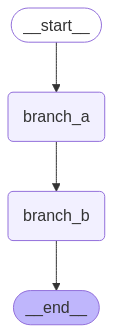

In [21]:
display(Image(runnable.get_graph().draw_mermaid_png()))

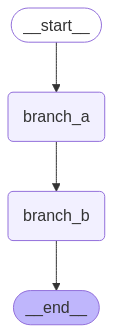

In [20]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        runnable.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [22]:
runnable.invoke({"string_value": "a"})

Current value: {'string_value': 'a'}
Current value: {'string_value': 'a'}


{'string_value': 'a'}

In [23]:
runnable.invoke({"string_value": "a", "numeric_value": 1})

Current value: {'string_value': 'a', 'numeric_value': 1}
Current value: {'string_value': 'a', 'numeric_value': 1}


{'string_value': 'a', 'numeric_value': 1}

In [28]:
def modify_state(input: InputState):
    input["string_value"] += "a"
    input["numeric_value"] += 1
    return input


graph = StateGraph(InputState)

graph.add_node("branch_a", modify_state)
graph.add_node("branch_b", modify_state)
graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_b", END)


graph.set_entry_point("branch_a")

runnable = graph.compile()

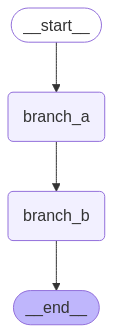

In [29]:
display(Image(runnable.get_graph().draw_mermaid_png()))


In [26]:
try:
    runnable.invoke({"string_value": "a"})
except KeyError as e:
    print(e)

'numeric_value'


In [27]:
runnable.invoke({"string_value": "a", "numeric_value": 1})

{'string_value': 'aaa', 'numeric_value': 3}

In [ ]:
display(Image(runnable.get_graph().draw_mermaid_png()))


### Why not use just LCEL?
Use LCEL for simple workflows and for complex, use LCEL inside a langgraph workflow.

In [9]:
from langchain_core.runnables import RunnableLambda

In [10]:
runnable = RunnableLambda(modify_state)

chain = runnable | runnable

In [11]:
chain.invoke({"string_value": "a", "numeric_value": 1})

{'string_value': 'aaa', 'numeric_value': 3}

### Cycles and Conditional Edges

In [30]:
def modify_state(input: InputState):
    input["string_value"] += "a"
    input["numeric_value"] += 1
    return input


def router(input: InputState):
    if input["numeric_value"] < 5:
        return "branch_a"
    else:
        return "__end__"


graph = StateGraph(InputState)

graph.add_node("branch_a", modify_state)
graph.add_node("branch_b", modify_state)

graph.add_edge("branch_a", "branch_b")

graph.add_conditional_edges(
    "branch_b", router, {"branch_a": "branch_a", "__end__": END}
)

graph.set_entry_point("branch_a")

runnable = graph.compile()

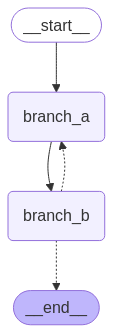

In [13]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        runnable.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [14]:
runnable.invoke({"string_value": "a", "numeric_value": 1})

{'string_value': 'aaaaa', 'numeric_value': 5}

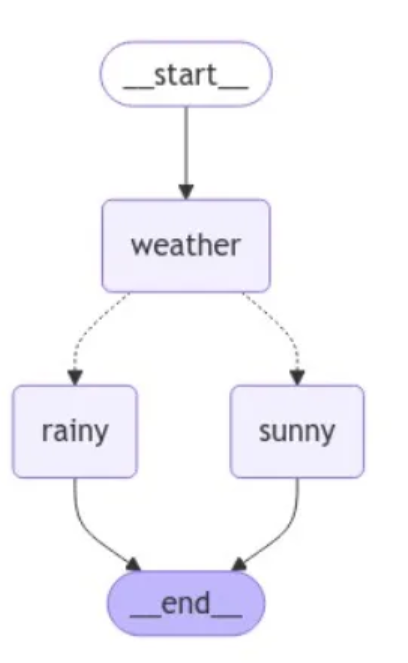

### Reducer functions

In [31]:
from typing import TypedDict, Annotated
from langgraph.graph import END, StateGraph
from operator import add


class InputState(TypedDict):
    no_change_value: str
    string_value: Annotated[str, add]
    numeric_value: Annotated[int, add]
    list_value: Annotated[list[str], add]


def modify_state(input: InputState):
    return input

In [32]:
graph = StateGraph(InputState)

graph.add_node("branch_a", modify_state)
graph.add_node("branch_b", modify_state)

graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_b", END)

graph.set_entry_point("branch_a")

runnable = graph.compile()

In [33]:
runnable.invoke(
    {
        "no_change_value": "a",
        "string_value": "a",
        "numeric_value": 1,
        "list_value": ["a"],
    }
)

{'no_change_value': 'a',
 'string_value': 'aaaa',
 'numeric_value': 4,
 'list_value': ['a', 'a', 'a', 'a']}

### Alternative State

In [17]:
from typing import TypedDict
from langgraph.graph import END, StateGraph


class InputState(TypedDict):
    string_value: str
    numeric_value: int


# class InputState(BaseModel):
#       string_value: str
#       numeric_value: int


def modify_state(input: InputState):
    string_value = input["string_value"]
    # string_value = input.string_value
    print(string_value)
    return input


graph = StateGraph(InputState)

graph.add_node("branch_a", modify_state)
graph.add_node("branch_b", modify_state)
graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_b", END)

graph.set_entry_point("branch_a")

runnable = graph.compile()

In [ ]:
runnable.invoke({"string_value": "a", "numeric_value": "a"})